In [93]:
import pandas as pd
import numpy as np
import igraph as ig

from importlib import resources
from scipy.sparse import csgraph

In [94]:
import vmlab
import matplotlib.pyplot as plt

# Get variable for explaining fruit growth

## Data

_Choose one tree and run the whole notebook at once_

In [95]:
# tree_name = 'E13'
# tree_name = 'E16'
tree_name = 'G3'

_Parameters to be changed_

In [96]:
if tree_name == 'E13':
    tree_path = resources.path('vmlab.data.trees', 'tree_E13_completed.csv')
elif tree_name == 'E16':
    tree_path = resources.path('vmlab.data.trees', 'tree_E16_completed.csv')
elif tree_name == 'G3':
    tree_path = resources.path('vmlab.data.trees', 'tree_G3_completed.csv')

tree = pd.read_csv(tree_path)
graph = vmlab.to_weighted_graph(tree)

# 'Nan not in index' : to avoid dealing with missing values, empty rows are assigned the mean value of sunlit instead
# for rows whose environment isn't specified : in exploration, multiplied by leaf number (=0 leaf anyways)
tree["environment_id"][pd.isna(tree["environment_id"])] = "mean"
tree['environment_id'][tree['environment_id']=='E16_14A']= 'mean'

C:\Users\bolot\AppData\Local\Temp\ipykernel_17700\3522364450.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["environment_id"][pd.isna(tree["environment_id"])] = "mean"
C:\Users\bolot\AppData\Local\Temp\ipykernel_17700\3522364450.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree['environment_id'][tree['environment_id']=='E16_14A']= 'mean'


In [97]:
with resources.path('vmlab.data.fruit_quality', 'fruits_masses.csv') as path:
    fruit_mass = pd.read_csv(path,
                             sep=";",
                             usecols=['id_UC', 'arbre', 'id_branche','id_fruit', 'MS_ini', 'MF_rec'],
                            )
fruit_mass.index=fruit_mass['id_UC']
fruit_mass.drop(columns = ['id_UC'], inplace=True)
fruit_mass = fruit_mass[fruit_mass['arbre']== tree_name ]
fruit_mass = fruit_mass[fruit_mass.index.notna()]

fruit_mass = fruit_mass.sort_index()

fruit_mass = fruit_mass.groupby(["id_UC"]).mean("MF_rec")
fruit_mass

id_branche    MS_ini  MF_rec
id_UC                               
6.0            3.0       NaN  464.00
58.0           2.0  7.500932  443.15
69.0           3.0       NaN   83.00
71.0           3.0  5.870691  370.00
165.0          1.0  5.607603  413.56
...            ...       ...     ...
1072.0        35.0       NaN  359.00
1073.0        35.0       NaN  319.00
1079.0        35.0  5.790799  427.54
1080.0        35.0       NaN  373.00
1122.0        34.0  6.757691  444.01

[64 rows x 3 columns]

In [98]:
tree['fruit_dry_mass'] = fruit_mass['MS_ini']
tree['fruit_fresh_mass'] = fruit_mass['MF_rec']
tree

id         type  parent_id  topology__is_apical  \
0        0        trunk        NaN                  NaN   
1        1     scaffold        0.0                  0.0   
2        2     scaffold        1.0                  1.0   
3        3           GU        2.0                  0.0   
4        4  multiple_GU        2.0                  1.0   
...    ...          ...        ...                  ...   
1135  1135           GU     1133.0                  0.0   
1136  1136           GU     1115.0                  0.0   
1137  1137           GU     1136.0                  1.0   
1138  1138           GU     1137.0                  1.0   
1139  1139     scaffold      558.0                  0.0   

     arch_dev__pot_flowering_date  arch_dev__pot_nb_inflo  \
0                             NAT                     NaN   
1                             NAT                     NaN   
2                             NAT                     NaN   
3                             NAT                     NaN   
4                             NaT                     NaN   
...                           ...                     ...   
1135                          NAT                     NaN   
1136                          NAT                     NaN   
1137                          NAT                     NaN   
1138                          NAT                     NaN   
1139                          NAT                     NaN   

      arch_dev__pot_nb_fruit  growth__nb_leaf  growth__radius_gu  \
0                        NaN              0.0          14.300000   
1                        NaN              0.0           6.210000   
2                        NaN              0.0           5.900000   
3                        NaN              0.0           2.108500   
4                        NaN              0.0           4.600000   
...                      ...              ...                ...   
1135                     NaN              8.0           0.220000   
1136                     NaN              0.0           0.302974   
1137                     NaN              2.0           0.243556   
1138                     NaN              6.0           0.170500   
1139                     NaN              0.0           5.410000   

      appearance__final_length_gu environment_id  \
0                              20           mean   
1                              20           mean   
2                              20           mean   
3                              20           mean   
4                              20           mean   
...                           ...            ...   
1135                            6         G3_34E   
1136                            8           mean   
1137                           13         G3_34D   
1138                            4         G3_34D   
1139                           44           mean   

      light_interception__sunlit_fraction_col  fruit_dry_mass  \
0                                           3             NaN   
1                                           3             NaN   
2                                           3             NaN   
3                                           3             NaN   
4                                           3             NaN   
...                                       ...             ...   
1135                                        3             NaN   
1136                                        3             NaN   
1137                                        3             NaN   
1138                                        3             NaN   
1139                                        3             NaN   

      fruit_fresh_mass  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
1135               NaN  
1136               NaN  
1137               NaN  
1138               NaN  
1139               NaN  

[1140 rows x 14 columns]

In [99]:
if tree_name == 'E13':
    sunlit_fractions_file_path = resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_E13.csv')
elif tree_name == 'E16':
    sunlit_fractions_file_path = resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_E16.csv')
elif tree_name == 'G3':
    sunlit_fractions_file_path = resources.path('vmlab.data.environment', 'fruting_season_sunlit_fractions_G3.csv')

sunlit_fraction_df = pd.read_csv(
            sunlit_fractions_file_path,
            sep='\\s+')
sunlit_fraction_df

G3_02D    G3_02E    G3_02G    G3_03A   G3_03C    G3_03D    G3_03E  \
0  0.216323  0.085417  0.078437  0.214229  0.14825  0.325344  0.040604   

     G3_03F    G3_04A    G3_04B  ...    G3_32E    G3_32G    G3_34A  G3_34B  \
0  0.120823  0.305896  0.184719  ...  0.028802  0.044792  0.103135   0.092   

     G3_34C    G3_34D    G3_34E    G3_35B        G3      mean  
0  0.109385  0.046542  0.180208  0.131604  0.084729  0.130779  

[1 rows x 144 columns]

## Correction of length of undescribed branches to repair missing topology

In [100]:
adjacency = np.array(graph.get_adjacency(attribute='weight'))
GUs = tree.loc[tree.loc[:,'type'] == 'GU']
is_fruting = tree["arch_dev__pot_nb_fruit"] > 0

In [101]:
distance_to_trunk = csgraph.shortest_path(adjacency,
                                    indices=0,
                                    directed=False,
                                    unweighted = False
                                    ).astype(np.int64)

In [102]:
distance_to_trunk = pd.DataFrame(distance_to_trunk, index = tree['id'], columns=['dist'])
distance_to_trunk['type'] = tree['type']
distance_to_trunk['length'] = tree['appearance__final_length_gu']
distance_to_trunk

dist         type  length
id                             
0        0        trunk      20
1       20     scaffold      20
2       40     scaffold      20
3       60           GU      20
4       60  multiple_GU      20
...    ...          ...     ...
1135   258           GU       6
1136   219           GU       8
1137   232           GU      13
1138   236           GU       4
1139   138     scaffold      44

[1140 rows x 3 columns]

In [103]:
sample = distance_to_trunk[distance_to_trunk['type']==('branch' or 'branch_empty')]
sample

dist    type  length
id                        
173    285  branch      20
229    292  branch      20
230    292  branch      20
322    369  branch      20
323    369  branch      20
326    393  branch      20
327    393  branch      20
328    393  branch      20
329    384  branch      20
330    384  branch      20
337    353  branch      20
338    353  branch      20
339    353  branch      20
345    354  branch      20
346    354  branch      20
347    354  branch      20
440    340  branch      20
441    340  branch      20
447    383  branch      20
448    383  branch      20
449    368  branch      20
451    342  branch      20
569    284  branch      20
570    284  branch      20
571    284  branch      20
573    252  branch      20
616    297  branch      20
617    297  branch      20
618    297  branch      20
619    297  branch      20
620    297  branch      20
621    297  branch      20
622    297  branch      20
626    316  branch      20
627    302  branch      20
628    302  branch      20
629    302  branch      20
630    302  branch      20
631    233  branch      20
740    301  branch      20
741    301  branch      20
742    301  branch      20
743    277  branch      20
744    277  branch      20
750    258  branch      20
751    246  branch      20
752    226  branch      20
1068   239  branch      20
1069   221  branch      20
1071   268  branch      20
1072   268  branch      20
1073   268  branch      20

We seek in the tree equivalent structures, to wit structures at the same distance from the trunk :

In [104]:
profondeurs = csgraph.shortest_path(adjacency,
                                  directed = True,
                                  unweighted = False).astype(np.float32)
profondeurs

array([[  0.,  20.,  40., ..., 232., 236., 138.],
       [ inf,   0.,  20., ...,  inf,  inf,  inf],
       [ inf,  inf,   0., ...,  inf,  inf,  inf],
       ...,
       [ inf,  inf,  inf, ...,   0.,   4.,  inf],
       [ inf,  inf,  inf, ...,  inf,   0.,  inf],
       [ inf,  inf,  inf, ...,  inf,  inf,   0.]], dtype=float32)

In [105]:
distance_to_trunk['profondeur'] = np.round([np.max(profondeurs[i][profondeurs[i] != np.inf]) for i in range (0, len(profondeurs))], decimals=0)
distance_to_trunk['profondeur_totale'] = distance_to_trunk['profondeur'] + distance_to_trunk['length']
distance_to_trunk

dist         type  length  profondeur  profondeur_totale
id                                                            
0        0        trunk      20       545.0              565.0
1       20     scaffold      20       267.0              287.0
2       40     scaffold      20       247.0              267.0
3       60           GU      20       209.0              229.0
4       60  multiple_GU      20       227.0              247.0
...    ...          ...     ...         ...                ...
1135   258           GU       6         0.0                6.0
1136   219           GU       8        17.0               25.0
1137   232           GU      13         4.0               17.0
1138   236           GU       4         0.0                4.0
1139   138     scaffold      44       253.0              297.0

[1140 rows x 5 columns]

In [106]:
sample

dist    type  length
id                        
173    285  branch      20
229    292  branch      20
230    292  branch      20
322    369  branch      20
323    369  branch      20
326    393  branch      20
327    393  branch      20
328    393  branch      20
329    384  branch      20
330    384  branch      20
337    353  branch      20
338    353  branch      20
339    353  branch      20
345    354  branch      20
346    354  branch      20
347    354  branch      20
440    340  branch      20
441    340  branch      20
447    383  branch      20
448    383  branch      20
449    368  branch      20
451    342  branch      20
569    284  branch      20
570    284  branch      20
571    284  branch      20
573    252  branch      20
616    297  branch      20
617    297  branch      20
618    297  branch      20
619    297  branch      20
620    297  branch      20
621    297  branch      20
622    297  branch      20
626    316  branch      20
627    302  branch      20
628    302  branch      20
629    302  branch      20
630    302  branch      20
631    233  branch      20
740    301  branch      20
741    301  branch      20
742    301  branch      20
743    277  branch      20
744    277  branch      20
750    258  branch      20
751    246  branch      20
752    226  branch      20
1068   239  branch      20
1069   221  branch      20
1071   268  branch      20
1072   268  branch      20
1073   268  branch      20

In [107]:
sample_mean_dist = pd.DataFrame(sample['type'].groupby(sample['dist']).min())

liste = []

for dist in sample_mean_dist.index :
    equivalent = distance_to_trunk[(distance_to_trunk['dist']== dist) & (distance_to_trunk['type']== 'GU')]
    if np.any(equivalent.index):
        liste.append(np.mean(equivalent['profondeur_totale']))
    else : 
        liste.append(np.nan)
sample_mean_dist['prof_moy_dist'] = liste

for i in sample_mean_dist.index :
    if pd.notna(sample_mean_dist.loc[i,'prof_moy_dist']) : 
        sample.loc[sample['dist']==i, 'prof_moy_dist'] = np.round(sample_mean_dist.loc[i,'prof_moy_dist'], decimals = 0)
    else : 
        sample.loc[sample['dist']==i, 'prof_moy_dist'] = np.round(np.nanmean(sample_mean_dist['prof_moy_dist']), decimals=0)

C:\Users\bolot\AppData\Local\Temp\ipykernel_17700\3789934157.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample.loc[sample['dist']==i, 'prof_moy_dist'] = np.round(sample_mean_dist.loc[i,'prof_moy_dist'], decimals = 0)


In [108]:
sample.sort_values('dist')

dist    type  length  prof_moy_dist
id                                       
1069   221  branch      20           38.0
752    226  branch      20          175.0
631    233  branch      20           24.0
1068   239  branch      20           91.0
751    246  branch      20           47.0
573    252  branch      20           28.0
750    258  branch      20           36.0
1071   268  branch      20           56.0
1072   268  branch      20           56.0
1073   268  branch      20           56.0
744    277  branch      20          124.0
743    277  branch      20          124.0
571    284  branch      20           30.0
569    284  branch      20           30.0
570    284  branch      20           30.0
173    285  branch      20           36.0
229    292  branch      20           24.0
230    292  branch      20           24.0
622    297  branch      20           58.0
621    297  branch      20           58.0
619    297  branch      20           58.0
618    297  branch      20           58.0
617    297  branch      20           58.0
616    297  branch      20           58.0
620    297  branch      20           58.0
742    301  branch      20           68.0
741    301  branch      20           68.0
740    301  branch      20           68.0
628    302  branch      20           87.0
627    302  branch      20           87.0
630    302  branch      20           87.0
629    302  branch      20           87.0
626    316  branch      20           26.0
441    340  branch      20           18.0
440    340  branch      20           18.0
451    342  branch      20           27.0
339    353  branch      20           26.0
337    353  branch      20           26.0
338    353  branch      20           26.0
347    354  branch      20           16.0
346    354  branch      20           16.0
345    354  branch      20           16.0
449    368  branch      20           42.0
322    369  branch      20            9.0
323    369  branch      20            9.0
447    383  branch      20           10.0
448    383  branch      20           10.0
329    384  branch      20           21.0
330    384  branch      20           21.0
327    393  branch      20           12.0
326    393  branch      20           12.0
328    393  branch      20           12.0

tree2 is the copy of the original tree, but with corrected length for undescribed branches.

In [109]:
tree2 = tree.copy()
tree2.loc[sample.index, 'appearance__final_length_gu'] = np.round(sample['prof_moy_dist'], decimals=0)

In [110]:
tree

id         type  parent_id  topology__is_apical  \
0        0        trunk        NaN                  NaN   
1        1     scaffold        0.0                  0.0   
2        2     scaffold        1.0                  1.0   
3        3           GU        2.0                  0.0   
4        4  multiple_GU        2.0                  1.0   
...    ...          ...        ...                  ...   
1135  1135           GU     1133.0                  0.0   
1136  1136           GU     1115.0                  0.0   
1137  1137           GU     1136.0                  1.0   
1138  1138           GU     1137.0                  1.0   
1139  1139     scaffold      558.0                  0.0   

     arch_dev__pot_flowering_date  arch_dev__pot_nb_inflo  \
0                             NAT                     NaN   
1                             NAT                     NaN   
2                             NAT                     NaN   
3                             NAT                     NaN   
4                             NaT                     NaN   
...                           ...                     ...   
1135                          NAT                     NaN   
1136                          NAT                     NaN   
1137                          NAT                     NaN   
1138                          NAT                     NaN   
1139                          NAT                     NaN   

      arch_dev__pot_nb_fruit  growth__nb_leaf  growth__radius_gu  \
0                        NaN              0.0          14.300000   
1                        NaN              0.0           6.210000   
2                        NaN              0.0           5.900000   
3                        NaN              0.0           2.108500   
4                        NaN              0.0           4.600000   
...                      ...              ...                ...   
1135                     NaN              8.0           0.220000   
1136                     NaN              0.0           0.302974   
1137                     NaN              2.0           0.243556   
1138                     NaN              6.0           0.170500   
1139                     NaN              0.0           5.410000   

      appearance__final_length_gu environment_id  \
0                              20           mean   
1                              20           mean   
2                              20           mean   
3                              20           mean   
4                              20           mean   
...                           ...            ...   
1135                            6         G3_34E   
1136                            8           mean   
1137                           13         G3_34D   
1138                            4         G3_34D   
1139                           44           mean   

      light_interception__sunlit_fraction_col  fruit_dry_mass  \
0                                           3             NaN   
1                                           3             NaN   
2                                           3             NaN   
3                                           3             NaN   
4                                           3             NaN   
...                                       ...             ...   
1135                                        3             NaN   
1136                                        3             NaN   
1137                                        3             NaN   
1138                                        3             NaN   
1139                                        3             NaN   

      fruit_fresh_mass  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
1135               NaN  
1136               NaN  
1137               NaN  
1138               NaN  
1139               NaN  

[1140 rows x 14 columns]

In [111]:
tree2

id         type  parent_id  topology__is_apical  \
0        0        trunk        NaN                  NaN   
1        1     scaffold        0.0                  0.0   
2        2     scaffold        1.0                  1.0   
3        3           GU        2.0                  0.0   
4        4  multiple_GU        2.0                  1.0   
...    ...          ...        ...                  ...   
1135  1135           GU     1133.0                  0.0   
1136  1136           GU     1115.0                  0.0   
1137  1137           GU     1136.0                  1.0   
1138  1138           GU     1137.0                  1.0   
1139  1139     scaffold      558.0                  0.0   

     arch_dev__pot_flowering_date  arch_dev__pot_nb_inflo  \
0                             NAT                     NaN   
1                             NAT                     NaN   
2                             NAT                     NaN   
3                             NAT                     NaN   
4                             NaT                     NaN   
...                           ...                     ...   
1135                          NAT                     NaN   
1136                          NAT                     NaN   
1137                          NAT                     NaN   
1138                          NAT                     NaN   
1139                          NAT                     NaN   

      arch_dev__pot_nb_fruit  growth__nb_leaf  growth__radius_gu  \
0                        NaN              0.0          14.300000   
1                        NaN              0.0           6.210000   
2                        NaN              0.0           5.900000   
3                        NaN              0.0           2.108500   
4                        NaN              0.0           4.600000   
...                      ...              ...                ...   
1135                     NaN              8.0           0.220000   
1136                     NaN              0.0           0.302974   
1137                     NaN              2.0           0.243556   
1138                     NaN              6.0           0.170500   
1139                     NaN              0.0           5.410000   

      appearance__final_length_gu environment_id  \
0                              20           mean   
1                              20           mean   
2                              20           mean   
3                              20           mean   
4                              20           mean   
...                           ...            ...   
1135                            6         G3_34E   
1136                            8           mean   
1137                           13         G3_34D   
1138                            4         G3_34D   
1139                           44           mean   

      light_interception__sunlit_fraction_col  fruit_dry_mass  \
0                                           3             NaN   
1                                           3             NaN   
2                                           3             NaN   
3                                           3             NaN   
4                                           3             NaN   
...                                       ...             ...   
1135                                        3             NaN   
1136                                        3             NaN   
1137                                        3             NaN   
1138                                        3             NaN   
1139                                        3             NaN   

      fruit_fresh_mass  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
1135               NaN  
1136               NaN  
1137               NaN  
1138               NaN  
1139               NaN  

[1140 rows x 14 columns]

In [112]:
graph = vmlab.to_weighted_graph(tree2)

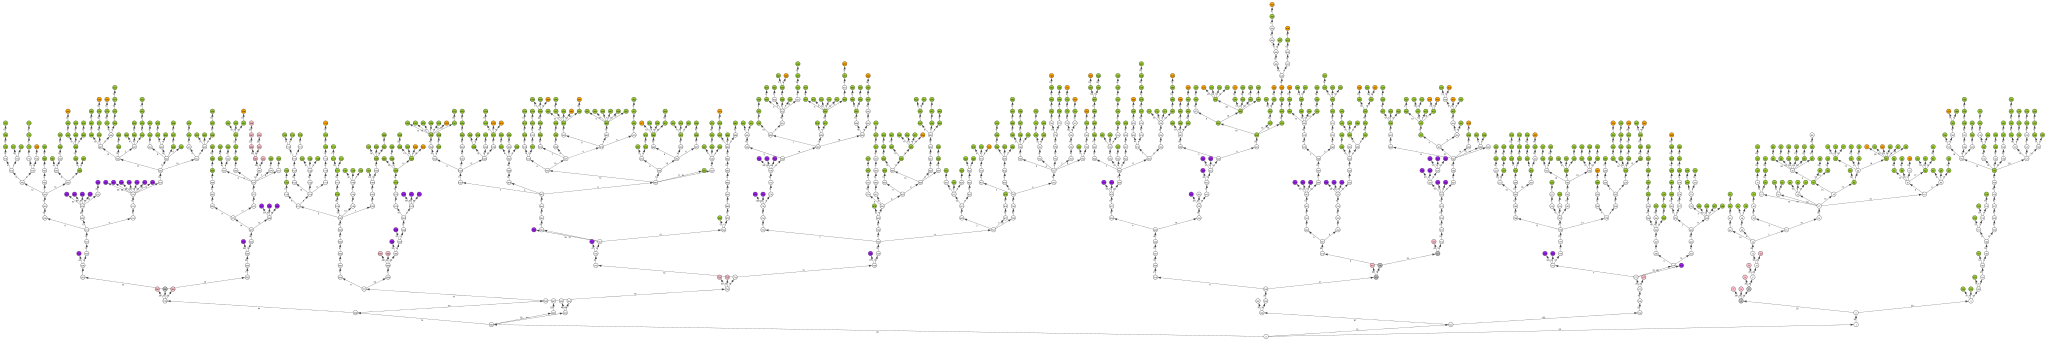

In [113]:
layout = graph.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph, 
    bbox=(0,0,9000,1500), 
    layout=layout, 
    vertex_label=graph.vs.get_attribute_values('id'), 
    vertex_label_size=8.5,
    vertex_color=['purple' if m == "branch" else 'grey' if n == ("multiple_GU" or "undefined")  else 'pink' if o == ("branch_empty" or "scaffold_empty") else 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for f, l,m,n,o in zip(
        graph.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph.vs.get_attribute_values('growth__nb_leaf'),
        graph.vs.get_attribute_values('type'),
        graph.vs.get_attribute_values('type'),
        graph.vs.get_attribute_values('type'))],
    edge_label = graph.es['weight'],
    edge_label_size = 9)

# Impact of distance on carbon flow

Geometric distance is used in other tree fruit growth models to ease carbon flow with the distance between the source and the sink (QualiTree, Miras-Avalos (2011) and  Musca, Reyes (2019)). A distance functions affects, for each fruit, a coefficient based on the distance from the fruit to every GU of the tree. This coefficient eases the carbon flow in the carbon allocation computation.

## Distance function

In [114]:
happ = 0.5 #example value of the h friction parameter
kapp = 0.5 #example value of the k parameter

In [115]:
def distance_impact_qualitree (distance, k):
    return distance**(-k)

Text(0, 0.5, 'coefficient')

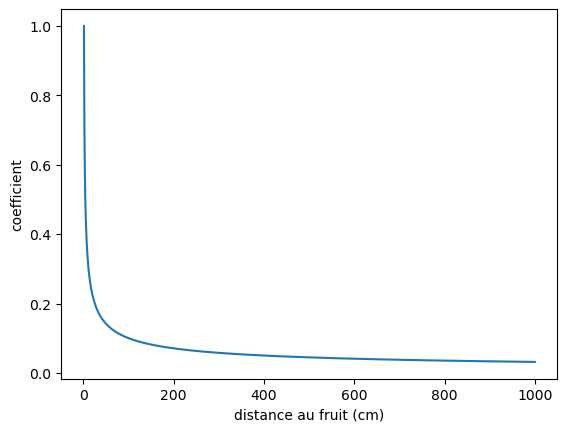

In [116]:
x = [i for i in np.linspace(1, 1000, 1000)]
y = [distance_impact_qualitree(i, kapp) for i in x]
plt.plot(x, y)
plt.xlabel("distance au fruit (cm)")
plt.ylabel("coefficient")

The distance function from Musca model is used here, because it includes the distance=0 which is in our case the GU bearing the fruit itself. This was not the case with the distance function from QualiTree model.

In [117]:
def distance_impact_musca (distance, h):
    return 1/((1+distance)**h)

h is a friction parameter, tested in a range of 0.5–16 for Musca (apple tree model) : best results between 4 and 8.

Text(0, 0.5, 'coefficient')

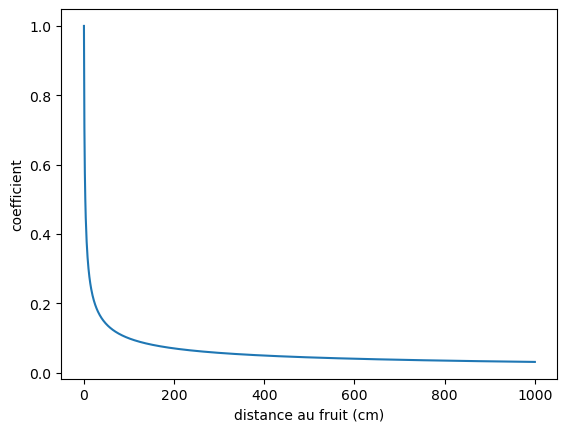

In [118]:
x = [i for i in np.linspace(0, 1000, 1000)]
y = [distance_impact_musca(i, happ) for i in x]
plt.plot(x, y)
plt.xlabel("distance au fruit (cm)")
plt.ylabel("coefficient")

A compromise function could also be used to get good aspects of both functions above :

In [119]:
def distance_impact_corr (distance, k):
    return (1+distance)**(-k)

Text(0, 0.5, 'coefficient')

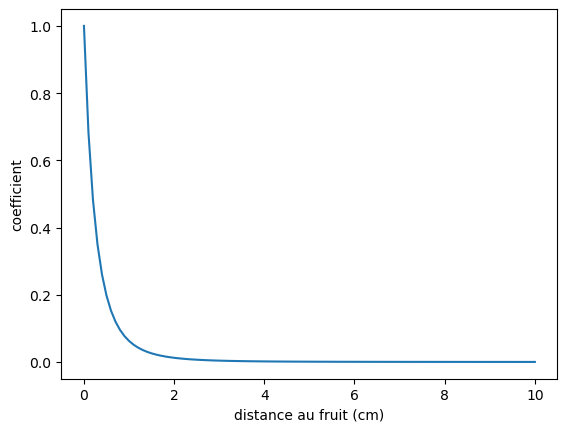

In [120]:
x = [i for i in np.linspace(0, 10, 101)]
y = [distance_impact_corr(i, 4) for i in x]
plt.plot(x, y)
plt.xlabel("distance au fruit (cm)")
plt.ylabel("coefficient")

In this notebook, only Musca distance function will be tested. It could be interesting to see what happes with the other distance function.

## Tries on an immaginary tree structure

This aim is to understand how the coefficient has an impact on carbon fluxes toward the fruits.

In [121]:
with resources.path('vmlab.data.trees', 'tree_test.csv') as path:
    tree_test = pd.read_csv(path)
    graph_test = vmlab.to_weighted_graph(tree_test)

In [122]:
print("\nEdges\n")
for e in graph_test.es():
    print("source: %s target: %d" % (e.source, e.target))
    print("multiplicity %d" % (graph_test.count_multiple(e)))
    print("weight %f\n" % e['weight'])


Edges

source: 0 target: 1
multiplicity 1
weight 4.000000

source: 1 target: 2
multiplicity 1
weight 6.000000

source: 1 target: 3
multiplicity 1
weight 6.000000

source: 3 target: 4
multiplicity 1
weight 12.000000

source: 4 target: 5
multiplicity 1
weight 6.000000

source: 5 target: 6
multiplicity 1
weight 6.000000

source: 4 target: 7
multiplicity 1
weight 7.000000

source: 3 target: 8
multiplicity 1
weight 13.000000

source: 8 target: 9
multiplicity 1
weight 5.000000

source: 8 target: 10
multiplicity 1
weight 6.000000

source: 8 target: 11
multiplicity 1
weight 5.000000



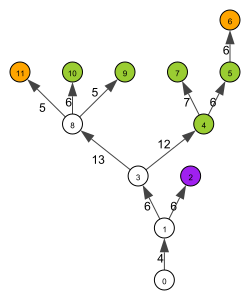

In [123]:
layout = graph_test.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph_test, 
    bbox=(0,0,250,300), 
    layout=layout,
    vertex_label=graph_test.vs.get_attribute_values('id'),
    vertex_label_size=8,
    edge_label = graph_test.es['weight'],
    edge_label_size = 12,
    vertex_color=['purple' if m == "branch" else 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for m,f,l in zip(
        graph_test.vs.get_attribute_values('type'),
        graph_test.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph_test.vs.get_attribute_values('growth__nb_leaf')
    )])

In [124]:
adjacency_test = np.array(graph_test.get_adjacency(attribute='weight'))
distance_to_fruit_test = csgraph.shortest_path(adjacency_test,
                                                indices = np.flatnonzero(tree_test['arch_dev__pot_nb_fruit']>0),
                                                directed= False,
                                                unweighted = False).astype(np.float32)

In [125]:
coef = np.round(distance_impact_musca(distance_to_fruit_test, h=happ), decimals=2)
coef

array([[0.17, 0.18, 0.16, 0.2 , 0.28, 0.38, 1.  , 0.22, 0.16, 0.15, 0.15,
        0.15],
       [0.19, 0.2 , 0.18, 0.23, 0.18, 0.16, 0.15, 0.16, 0.41, 0.3 , 0.29,
        1.  ]], dtype=float32)

Plot in which vertex label is the coefficient due to distance for the first fruit :

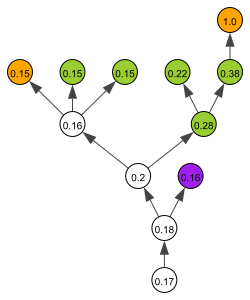

In [126]:
layout = graph_test.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph_test, 
    bbox=(0,0,250,300), 
    layout=layout,
    vertex_label = coef[0],
    vertex_size = 25,
    vertex_label_size = 10,
    vertex_color=['purple' if m == "branch" else 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for m,f,l in zip(
        graph_test.vs.get_attribute_values('type'),
        graph_test.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph_test.vs.get_attribute_values('growth__nb_leaf')
    )])

Plot in which vertex label is the coefficient due to distance for the second fruit :

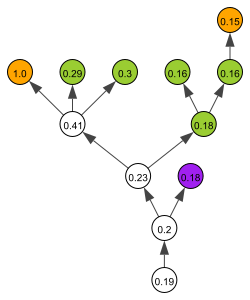

In [127]:
layout = graph_test.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph_test, 
    bbox=(0,0,250,300), 
    layout=layout,
    vertex_label = coef[1],
    vertex_size = 25,
    vertex_label_size = 10,
    vertex_color=['purple' if m == "branch" else 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for m,f,l in zip(
        graph_test.vs.get_attribute_values('type'),
        graph_test.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph_test.vs.get_attribute_values('growth__nb_leaf')
    )])

The missing branch (in purple, not described) is reconstructed to see if the carbon flux estimated with the purple structure would be close to the carbon flux from the "real" structure.

In [128]:
with resources.path('vmlab.data.trees', 'tree_test_rec.csv') as path:
    tree_test_rec = pd.read_csv(path)
    graph_test = vmlab.to_weighted_graph(tree_test_rec)

In [129]:
adjacency_test = np.array(graph_test.get_adjacency(attribute='weight'))
distance_to_fruit_test = csgraph.shortest_path(adjacency_test,
                                                indices = [11, 6],
                                                directed= False,
                                                unweighted = False).astype(np.float32)

In [130]:
coef = np.round(distance_impact_musca(distance_to_fruit_test, h=happ), decimals=2)
coef

array([[0.19, 0.2 , 0.18, 0.23, 0.18, 0.16, 0.15, 0.16, 0.41, 0.3 , 0.29,
        1.  , 0.15, 0.14, 0.14, 0.14, 0.14],
       [0.17, 0.18, 0.16, 0.2 , 0.28, 0.38, 1.  , 0.22, 0.16, 0.15, 0.15,
        0.15, 0.14, 0.13, 0.13, 0.14, 0.13]], dtype=float32)

Plot in which vertex label is the coefficient due to distance for the first fruit :

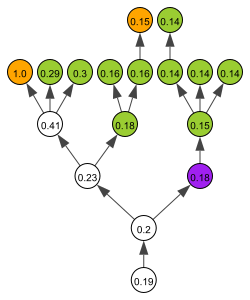

In [131]:
layout11 = graph_test.layout_reingold_tilford()
layout11.rotate(180)
ig.plot(
    graph_test, 
    bbox=(0,0,250,300), 
    layout=layout11,
    vertex_label = coef[0],
    vertex_size = 25,
    vertex_label_size = 10,
    vertex_color=['purple' if m == "branch" else 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for m,f,l in zip(
        graph_test.vs.get_attribute_values('type'),
        graph_test.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph_test.vs.get_attribute_values('growth__nb_leaf')
    )])

Plot in which vertex label is the coefficient due to distance for the second fruit :

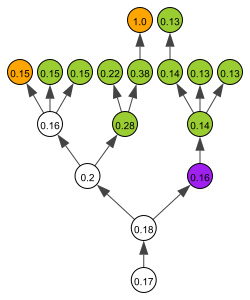

In [132]:
layout6 = graph_test.layout_reingold_tilford()
layout6.rotate(180)
ig.plot(
    graph_test, 
    bbox=(0,0,250,300), 
    layout=layout6,
    vertex_label = coef[1],
    vertex_size = 25,
    vertex_label_size = 10,
    vertex_color=['purple' if m == "branch" else 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for m,f,l in zip(
        graph_test.vs.get_attribute_values('type'),
        graph_test.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph_test.vs.get_attribute_values('growth__nb_leaf')
    )])

**Conclusion** : the coefficients of the GU "trully" bearing the leaves are reduced, since they are located further to the fruit than the purpule structure which represents them. The carbon fluxes (calculated by hand) are thus decreased. Let's compared this to results obtained with Vmango :

In [133]:
def fun_test(architecture: pd.DataFrame, h: float) : 
    graph = vmlab.to_weighted_graph(architecture)
    adjacency = np.array(graph.get_adjacency(attribute='weight'))

    distance_to_fruit = np.array([], dtype= float)
    is_fruting = architecture['arch_dev__pot_nb_fruit'] > 0

    if np.any(is_fruting) :
        distance_to_fruit = csgraph.shortest_path(
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False,
                                    unweighted = False
                                    ).astype( float)
        
    carbon_flow_raw  = distance_to_fruit.copy()
    carbon_flow_shared  = distance_to_fruit.copy()
    coef_distance = distance_impact_musca(distance_to_fruit, h)
    print('coef distance :', coef_distance)

    for j in range (0, len(distance_to_fruit)):
        carbon_flow_raw[j] = (coef_distance[j] * architecture["growth__nb_leaf"]) #envoi de carbone sans limitation 
        carbon_flow_shared[j] = (coef_distance[j] * architecture["growth__nb_leaf"]) / np.nansum(coef_distance, axis=0) # envoi d'autant de carbone que disponible dans les feuilles

    return carbon_flow_raw, carbon_flow_shared

In [134]:
fun_test(tree_test, 0.4)

coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276]
 [0.26004039 0.27594593 0.25319512 0.30796301 0.25319512 0.23589531
  0.22213276 0.23339232 0.48835934 0.38321538 0.37010717 1.        ]]


(array([[0.        , 0.        , 8.72812655, 0.        , 0.71689022,
         1.37746965, 3.        , 2.11196172, 0.        , 2.66559315,
         0.88039774, 0.44426553],
        [0.        , 0.        , 9.36821926, 0.        , 0.50639023,
         0.70768594, 0.66639829, 1.63374624, 0.        , 4.59858451,
         1.48042869, 2.        ]]),
 array([[ 0.        ,  0.        , 17.84562949,  0.        ,  1.17207827,
          1.98182283,  2.45472513,  3.94684588,  0.        ,  4.40340522,
          1.4916772 ,  0.36351658],
        [ 0.        ,  0.        , 19.15437051,  0.        ,  0.82792173,
          1.01817717,  0.54527487,  3.05315412,  0.        ,  7.59659478,
          2.5083228 ,  1.63648342]]))

In [135]:
fun_test(tree_test_rec, 0.4)

coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276
  0.21257075 0.20130517 0.20130517 0.20278811 0.19441936]
 [0.26004039 0.27594593 0.25319512 0.30796301 0.25319512 0.23589531
  0.22213276 0.23339232 0.48835934 0.38321538 0.37010717 1.
  0.22423339 0.21082474 0.21082474 0.21257075 0.20278811]]


(array([[0.        , 0.        , 0.        , 0.        , 0.71689022,
         1.37746965, 3.        , 2.11196172, 0.        , 2.66559315,
         0.88039774, 0.44426553, 1.06285375, 1.20783101, 1.81174651,
         1.01394057, 0.19441936],
        [0.        , 0.        , 0.        , 0.        , 0.50639023,
         0.70768594, 0.66639829, 1.63374624, 0.        , 4.59858451,
         1.48042869, 2.        , 1.12116695, 1.26494842, 1.89742264,
         1.06285375, 0.20278811]]),
 array([[0.        , 0.        , 0.        , 0.        , 1.17207827,
         1.98182283, 2.45472513, 3.94684588, 0.        , 4.40340522,
         1.4916772 , 0.36351658, 2.43325017, 2.9307046 , 4.39605689,
         2.44111937, 0.48946551],
        [0.        , 0.        , 0.        , 0.        , 0.82792173,
         1.01817717, 0.54527487, 3.05315412, 0.        , 7.59659478,
         2.5083228 , 1.63648342, 2.56674983, 3.0692954 , 4.60394311,
         2.55888063, 0.51053449]]))

In [136]:
np.sum([fun_test(tree_test_rec, 0.4)[0][0][i] for i in [12,13,14,15,16]]), np.sum([fun_test(tree_test_rec, 0.4)[0][1][i] for i in [12,13,14,15,16]])

coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276
  0.21257075 0.20130517 0.20130517 0.20278811 0.19441936]
 [0.26004039 0.27594593 0.25319512 0.30796301 0.25319512 0.23589531
  0.22213276 0.23339232 0.48835934 0.38321538 0.37010717 1.
  0.22423339 0.21082474 0.21082474 0.21257075 0.20278811]]
coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276
  0.21257075 0.20130517 0.20130517 0.20278811 0.19441936]
 [0.26004039 0.27594593 0.25319512 0.30796301 0.25319512 0.23589531
  0.22213276 0.23339232 0.48835934 0.38321538 0.37010717 1.
  0.22423339 0.21082474 0.21082474 0.21257075 0.20278811]]
coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276
  0.21257075 0.20130517 0.20130517 0.20278811 0.194419

(5.290791194506841, 5.549179877952188)

In [137]:
np.sum([fun_test(tree_test_rec, 0.4)[1][0][i] for i in [12,13,14,15,16]]), np.sum([fun_test(tree_test_rec, 0.4)[1][1][i] for i in [12,13,14,15,16]])

coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276
  0.21257075 0.20130517 0.20130517 0.20278811 0.19441936]
 [0.26004039 0.27594593 0.25319512 0.30796301 0.25319512 0.23589531
  0.22213276 0.23339232 0.48835934 0.38321538 0.37010717 1.
  0.22423339 0.21082474 0.21082474 0.21257075 0.20278811]]
coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276
  0.21257075 0.20130517 0.20130517 0.20278811 0.19441936]
 [0.26004039 0.27594593 0.25319512 0.30796301 0.25319512 0.23589531
  0.22213276 0.23339232 0.48835934 0.38321538 0.37010717 1.
  0.22423339 0.21082474 0.21082474 0.21257075 0.20278811]]
coef distance : [[0.24119749 0.25319512 0.23589531 0.27594593 0.35844511 0.45915655
  1.         0.30170882 0.23339232 0.22213276 0.22009944 0.22213276
  0.21257075 0.20130517 0.20130517 0.20278811 0.194419

(12.690596541789274, 13.309403458210722)

Conclusion : the gap between the tree with and without the reconstructed missing branch appears to be quite high. Indeed, we have :

- a change from 5.3 to 12.7 for raw flux (but not biogically reliable) : **two times underestimated**

- a change from 5.5 to 13.3 for shared flux : **two times underestimated**


The deepth of these undescribed structures have thus to be taken into account. (CF "Correction of length for undescribed branches")

## Tries on the tree structure

In [138]:
graph = vmlab.to_weighted_graph(tree2)
adjacency = np.array(graph.get_adjacency(attribute='weight'))
GUs = tree2.loc[tree2.loc[:,'type'] == 'GU']
is_fruting = tree2["arch_dev__pot_nb_fruit"] > 0

In [139]:
distances = csgraph.shortest_path(adjacency,
                                    directed=False,
                                    unweighted = False
                                    ).astype(np.float32)
distances

array([[  0.,  20.,  40., ..., 232., 236., 138.],
       [ 20.,   0.,  20., ..., 252., 256., 158.],
       [ 40.,  20.,   0., ..., 272., 276., 178.],
       ...,
       [232., 252., 272., ...,   0.,   4., 182.],
       [236., 256., 276., ...,   4.,   0., 186.],
       [138., 158., 178., ..., 182., 186.,   0.]], dtype=float32)

In [140]:
distance_to_fruit = csgraph.shortest_path(
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False,
                                    unweighted = False
                                    ).astype(np.float32)

In [141]:
distance_to_fruit

array([[259., 239., 219., ..., 491., 495., 397.],
       [268., 248., 228., ..., 500., 504., 406.],
       [273., 253., 233., ..., 505., 509., 411.],
       ...,
       [312., 332., 352., ..., 236., 240., 262.],
       [308., 328., 348., ..., 232., 236., 258.],
       [261., 281., 301., ...,  71.,  75., 211.]], dtype=float32)

In [142]:
coef_distance = distance_impact_musca(distance_to_fruit, happ)
coef_distance = pd.DataFrame(np.round(coef_distance, decimals=2), index = np.flatnonzero(is_fruting))
coef_distance

0     1     2     3     4     5     6     7     8     9     ...  1130  \
58    0.06  0.06  0.07  0.06  0.07  0.07  0.07  0.07  0.08  0.07  ...  0.04   
69    0.06  0.06  0.07  0.06  0.07  0.07  0.07  0.07  0.08  0.07  ...  0.04   
71    0.06  0.06  0.07  0.06  0.07  0.07  0.07  0.07  0.08  0.07  ...  0.04   
165   0.06  0.06  0.07  0.07  0.06  0.06  0.06  0.06  0.06  0.06  ...  0.04   
173   0.06  0.06  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  ...  0.04   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1072  0.06  0.06  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  ...  0.06   
1073  0.06  0.06  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  ...  0.06   
1079  0.06  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  ...  0.06   
1080  0.06  0.06  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  ...  0.06   
1122  0.06  0.06  0.06  0.06  0.06  0.05  0.05  0.05  0.05  0.05  ...  0.12   

      1131  1132  1133  1134  1135  1136  1137  1138  1139  
58    0.04  0.04  0.04  0.04  0.04  0.05  0.05  0.04  0.05  
69    0.04  0.04  0.04  0.04  0.04  0.05  0.04  0.04  0.05  
71    0.04  0.04  0.04  0.04  0.04  0.05  0.04  0.04  0.05  
165   0.04  0.04  0.04  0.04  0.04  0.05  0.05  0.04  0.05  
173   0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.04  0.05  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
1072  0.06  0.06  0.06  0.06  0.06  0.07  0.07  0.07  0.06  
1073  0.06  0.06  0.06  0.06  0.06  0.07  0.07  0.07  0.06  
1079  0.06  0.06  0.06  0.06  0.06  0.07  0.06  0.06  0.06  
1080  0.06  0.06  0.06  0.06  0.06  0.07  0.07  0.06  0.06  
1122  0.12  0.12  0.12  0.11  0.11  0.13  0.12  0.11  0.07  

[63 rows x 1140 columns]

In [143]:
table = pd.DataFrame(np.nansum(coef_distance, axis=0), index = tree['id'])

In [144]:
for i in table.index :
    if table.loc[i,0] == 0:
        print("0:", i)
    elif table.loc[i,0] == 1:
        print("1:", i)
    

In [145]:
chosen_fruit= np.flatnonzero(is_fruting)[3]

In [146]:
layout = graph.layout_reingold_tilford()
layout.rotate(180)
ig.plot(
    graph, 
    bbox=(0,0,9000,1300), 
    layout=layout,
    vertex_label=graph.vs.get_attribute_values('id'),
    vertex_label_size=10,
    edge_label = np.round(coef_distance.loc[chosen_fruit], decimals= 2),
    edge_label_size = 12,
    vertex_color=['purple' if m == "branch" else 'orange' if f > 0 else 'yellowgreen' if l > 0 else 'white' for m,f,l in zip(
        graph.vs.get_attribute_values('type'),
        graph.vs.get_attribute_values('arch_dev__pot_nb_fruit'),
        graph.vs.get_attribute_values('growth__nb_leaf')
    )])

In [147]:
np.flatnonzero(np.flatnonzero(is_fruting)==chosen_fruit)

array([3], dtype=int64)

## Functions for carbon flow computation

<u> Carbon flow from source i to sink j (QualiTree) : <u>

Fij =coef_distance ij * (ACPi * Demand j)/(sum(Demand in the whole tree))

<u> Carbon flow from source i to sink j (Musca) : <u>

Fij = (coef_distance ij * ACPi * Demand j)/(sum(coef_distance*Demand in the whole tree))

In [148]:
def get_var_fruit_growth(tree: pd.DataFrame, year_sunlit_fractions: pd.DataFrame, h: float, demand: str, distance: distance_impact_musca) : 
    '''
    Returns the carbon available for each GU bearing a fruit in the input tree with different ways of computing it.
    
    Parameters
    ----------
    tree : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'tree' input in the vmlab.create_setup function. A 'environment_id' column is also required.

    year_sunlit_fractions : :class:`pandas.DataFrame` object
        Required format is identical with what is specified for the 'sunlit_fraction_df' input in the vmlab.processes.light_interception initialization.

    h : :class:`float` object
        Friction parameter for mango wood towards carbon flow.

    demand : :class:`str` object
        Type of sink carbon demand in carbon flow computing : 'DM' (dry mass), 'FM' (fresh mass) or '1' (no mass).

    distance : :class:`function` object
        The function impact distance to be used. 'distance_impact_musca', or 'distance_impact_qualitree' or 'distance_impact_corr'.

    Returns
    -------
    available_carbon_raw, available_carbon_shared,available_carbon_lit_env : :class:`numpay.array
    '''

    graph = vmlab.to_weighted_graph(tree)
    adjacency = np.array(graph.get_adjacency(attribute='weight'))

    # Initializaton (setting dtypes)
    distance_to_fruit = np.array([], dtype= float)
    is_fruting = tree['arch_dev__pot_nb_fruit'] > 0

    if np.any(is_fruting) :
        distance_to_fruit = csgraph.shortest_path(
                                    adjacency,
                                    indices=np.flatnonzero(is_fruting),
                                    directed=False,
                                    unweighted = False
                                    ).astype( float)
        
    carbon_flow_raw  = distance_to_fruit.copy()
    carbon_flow_shared  = distance_to_fruit.copy()
    carbon_flow_lit_env  = distance_to_fruit.copy()
    coef_distance = distance(distance_to_fruit, h)
    carbon_sinks = np.copy(coef_distance)

    if distance == distance_impact_musca : 
        if demand == 'DM' :
            for j in range (0, len(coef_distance[0])) :
                carbon_sinks[:,j] = coef_distance[:,j] * tree.loc[np.flatnonzero(is_fruting), 'fruit_dry_mass'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
        elif demand == 'FM' :
            for j in range (0, len(coef_distance[0])) :
                carbon_sinks[:,j] = coef_distance[:,j] * tree.loc[np.flatnonzero(is_fruting), 'fruit_fresh_mass'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
        else :
            for j in range (0, len(coef_distance[0])) :
                carbon_sinks[:,j] = coef_distance[:,j] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
        for j in range (0, len(distance_to_fruit)):
                # carbon flow without limitation by other sinks : 
            carbon_flow_raw[j] = (carbon_sinks[j] * tree["growth__nb_leaf"]) 
                # carbon flow according to leaves capacity to supply all the sinks : 
            carbon_flow_shared[j] = (carbon_sinks[j] * tree["growth__nb_leaf"]  ) / np.nansum(carbon_sinks, axis=0) 
                # carbon flow according to leaves capacity to supply all the sinks within photosynthesis limitation : 
            carbon_flow_lit_env[j] = (carbon_sinks[j] * tree["growth__nb_leaf"] * year_sunlit_fractions[tree["environment_id"]].to_numpy()[0] ) / np.nansum(carbon_sinks, axis=0) 

    else :
        if demand == 'DM' :
            for j in range (0, len(coef_distance[0])) :
                carbon_sinks[:,j] = tree.loc[np.flatnonzero(is_fruting), 'fruit_dry_mass'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
        elif demand == 'FM' :
            for j in range (0, len(coef_distance[0])) :
                carbon_sinks[:,j] = tree.loc[np.flatnonzero(is_fruting), 'fruit_fresh_mass'] * tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
        else :
            for j in range (0, len(coef_distance[0])) :
                carbon_sinks[:,j] = tree.loc[np.flatnonzero(is_fruting), 'arch_dev__pot_nb_fruit']
 
        for j in range (0, len(distance_to_fruit)):
                # carbon flow without limitation by other sinks : 
            carbon_flow_raw[j] = (coef_distance[j]*carbon_sinks[j] * tree["growth__nb_leaf"]) 
                # carbon flow according to leaves capacity to supply all the sinks : 
            carbon_flow_shared[j] = (coef_distance[j]*carbon_sinks[j] * tree["growth__nb_leaf"]  ) / np.nansum(carbon_sinks, axis=0) 
                # carbon flow according to leaves capacity to supply all the sinks within photosynthesis limitation : 
            carbon_flow_lit_env[j] = (coef_distance[j]*carbon_sinks[j] * tree["growth__nb_leaf"] * year_sunlit_fractions[tree["environment_id"]].to_numpy()[0] ) / np.nansum(carbon_sinks, axis=0) 

        for j in range (0, len(distance_to_fruit)):
                # carbon flow without limitation by other sinks : 
            carbon_flow_raw[j] = (coef_distance[j]*carbon_sinks[j] * tree["growth__nb_leaf"]) 
                # carbon flow according to leaves capacity to supply all the sinks : 
            carbon_flow_shared[j] = (coef_distance[j]*carbon_sinks[j] * tree["growth__nb_leaf"]  ) / np.nansum(carbon_sinks, axis=0) 
                # carbon flow according to leaves capacity to supply all the sinks within photosynthesis limitation : 
            carbon_flow_lit_env[j] = (coef_distance[j]*carbon_sinks[j] * tree["growth__nb_leaf"] * year_sunlit_fractions[tree["environment_id"]].to_numpy()[0] ) / np.nansum(carbon_sinks, axis=0) 

    available_carbon_raw = np.round(np.nansum(carbon_flow_raw, axis=1), decimals=2)
    available_carbon_shared = np.round(np.nansum(carbon_flow_shared, axis=1), decimals=2)
    available_carbon_lit_env = np.round(np.nansum(carbon_flow_lit_env, axis=1), decimals=2)

    return available_carbon_raw, available_carbon_shared,available_carbon_lit_env

NB : we lack of data on initial dry masses to caracterize carbon sinks at the begining of fructification. The variable  'demand == DM' can be used for trees where all dry masses are known.

## Results

<u> Fruit number per GU as carbon demand : <u>

In [149]:
results = pd.DataFrame(get_var_fruit_growth(tree2, sunlit_fraction_df, h=happ, demand='1', distance = distance_impact_musca),
    index=["available_carbon_raw", "available_carbon_shared", "available_carbon_lit_env"],
    columns = np.flatnonzero(is_fruting))
results = np.transpose(results)
results['type'] = tree2["type"]
results['MF_rec'] = tree2["fruit_fresh_mass"]
results

available_carbon_raw  available_carbon_shared  available_carbon_lit_env  \
58                  788.43                   165.85                     22.47   
69                  772.03                   163.35                     23.00   
71                  385.54                    81.68                     11.55   
165                 368.83                    77.88                     10.55   
173                3015.24                   505.90                     67.63   
...                    ...                      ...                       ...   
1072                645.00                   131.01                     17.68   
1073               1215.71                   236.84                     32.07   
1079                421.18                    88.21                     12.10   
1080                424.45                    88.91                     12.20   
1122                428.69                    90.01                     12.40   

        type      MF_rec  
58        GU  443.150000  
69        GU   83.000000  
71        GU  370.000000  
165       GU  413.560000  
173   branch  345.666667  
...      ...         ...  
1072  branch  359.000000  
1073  branch  319.000000  
1079      GU  427.540000  
1080      GU  373.000000  
1122      GU  444.010000  

[63 rows x 5 columns]

<u> Fruit fresh masses as carbon demand :<u>

In [150]:
results = pd.DataFrame(get_var_fruit_growth(tree2, sunlit_fraction_df, h=happ, demand='FM', distance = distance_impact_musca),
    index=["available_carbon_raw", "available_carbon_shared", "available_carbon_lit_env"],
    columns = np.flatnonzero(is_fruting))
results = np.transpose(results)
results['type'] = tree2["type"]
results['MF_rec'] = tree2["fruit_fresh_mass"]
results

available_carbon_raw  available_carbon_shared  available_carbon_lit_env  \
58               349392.21                   191.56                     25.98   
69                64078.83                    35.57                      5.02   
71               142649.82                    79.01                     11.18   
165              152534.39                    83.91                     11.37   
173             1042266.88                   463.11                     61.88   
...                    ...                      ...                       ...   
1072             231554.64                   122.92                     16.59   
1073             387812.09                   199.50                     27.00   
1079             180069.48                    98.22                     13.47   
1080             158321.69                    86.39                     11.85   
1122             190344.17                   103.96                     14.32   

        type      MF_rec  
58        GU  443.150000  
69        GU   83.000000  
71        GU  370.000000  
165       GU  413.560000  
173   branch  345.666667  
...      ...         ...  
1072  branch  359.000000  
1073  branch  319.000000  
1079      GU  427.540000  
1080      GU  373.000000  
1122      GU  444.010000  

[63 rows x 5 columns]

<u>Fruit dry masses as carbon demand :<u>

In [151]:
results = pd.DataFrame(get_var_fruit_growth(tree2, sunlit_fraction_df, h=happ, demand='DM', distance = distance_impact_musca),
    index=["available_carbon_raw", "available_carbon_shared", "available_carbon_lit_env"],
    columns = np.flatnonzero(is_fruting))
results = np.transpose(results)
results['type'] = tree2["type"]
results['MF_rec'] = tree2["fruit_fresh_mass"]
results

available_carbon_raw  available_carbon_shared  available_carbon_lit_env  \
58                 5913.95                   391.08                     53.12   
69                    0.00                     0.00                      0.00   
71                 2263.39                   151.94                     21.34   
165                2068.27                   138.96                     18.76   
173                   0.00                     0.00                      0.00   
...                    ...                      ...                       ...   
1072                  0.00                     0.00                      0.00   
1073                  0.00                     0.00                      0.00   
1079               2438.94                   163.30                     22.30   
1080                  0.00                     0.00                      0.00   
1122               2896.98                   192.58                     26.38   

        type      MF_rec  
58        GU  443.150000  
69        GU   83.000000  
71        GU  370.000000  
165       GU  413.560000  
173   branch  345.666667  
...      ...         ...  
1072  branch  359.000000  
1073  branch  319.000000  
1079      GU  427.540000  
1080      GU  373.000000  
1122      GU  444.010000  

[63 rows x 5 columns]

Results can be plotted for each of the three results table :

In [152]:
results.drop(labels = [i for i in results.index if np.any(results.loc[i, "type"]!="GU")], inplace=True)
# results.drop(labels = [i for i in results.index if np.any(results.loc[i, "available_carbon_raw"]==0)], inplace=True)
# results.drop(labels = [i for i in results.index if np.any(results.loc[i, "available_carbon_shared"]==0)], inplace=True)
# results.drop(labels = [i for i in results.index if np.any(results.loc[i, "available_carbon_lit_env"]==0)], inplace=True)
results

available_carbon_raw  available_carbon_shared  available_carbon_lit_env  \
58                 5913.95                   391.08                     53.12   
69                    0.00                     0.00                      0.00   
71                 2263.39                   151.94                     21.34   
165                2068.27                   138.96                     18.76   
205                   0.00                     0.00                      0.00   
241                8610.13                   564.07                     77.79   
246                3137.91                   208.13                     29.45   
254                   0.00                     0.00                      0.00   
261                2031.10                   136.23                     18.13   
289                2871.99                   191.69                     25.27   
355                2352.48                   157.46                     21.53   
358                   0.00                     0.00                      0.00   
391                2751.23                   184.34                     24.83   
400                   0.00                     0.00                      0.00   
407                   0.00                     0.00                      0.00   
409                5486.38                   364.50                     51.20   
414                   0.00                     0.00                      0.00   
415                3021.80                   201.52                     29.36   
456                   0.00                     0.00                      0.00   
460                4271.34                   283.03                     40.01   
471                5219.22                   346.89                     48.93   
476                   0.00                     0.00                      0.00   
485                   0.00                     0.00                      0.00   
488                   0.00                     0.00                      0.00   
494                   0.00                     0.00                      0.00   
501                3246.49                   216.13                     29.80   
510                2549.64                   169.84                     22.50   
525                4126.50                   275.73                     37.34   
551                2403.70                   160.77                     21.80   
594                7265.57                   479.04                     66.41   
675                   0.00                     0.00                      0.00   
679                4726.04                   314.32                     44.51   
696                   0.00                     0.00                      0.00   
709                5231.36                   349.25                     48.09   
762                2568.34                   169.94                     23.38   
769                   0.00                     0.00                      0.00   
773                2150.10                   142.36                     19.40   
785                2342.50                   154.91                     21.32   
814                   0.00                     0.00                      0.00   
856                4418.77                   289.46                     40.38   
891                4409.42                   289.45                     39.18   
899                2269.91                   150.00                     21.10   
912                3079.13                   203.59                     28.59   
930                4511.15                   297.63                     41.64   
971                   0.00                     0.00                      0.00   
994                2594.17                   170.68                     24.13   
995                   0.00                     0.00                      0.00   
1007               6403.33                   421.69                     59.26   
1032               2672.64           

<Axes: xlabel='available_carbon_raw', ylabel='MF_rec'>

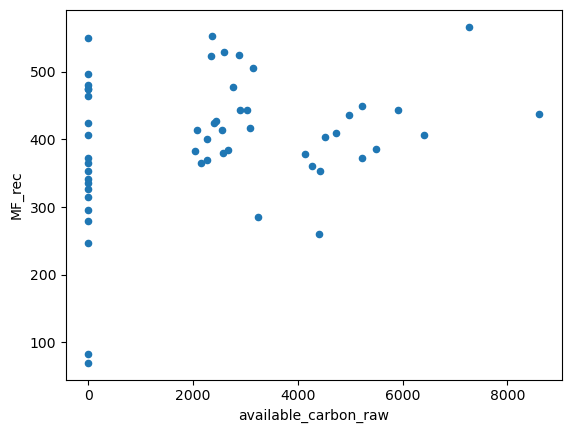

In [153]:
results.plot(kind = 'scatter', x= 'available_carbon_raw', y = 'MF_rec')

It seems difficult to find a relevant h to make the regression fit the data best.

### Results dataframes to find the h giving the best fit

In [154]:
# discrete h to be tested (minimum 10 values in total)
h_range = [0,1,2,3,4,5,6,7,8,9,10]

#### With fresh fruit mass in the explaining variables :

In [155]:
# collecting variables at the distance dmax :
results = [get_var_fruit_growth(tree2, sunlit_fraction_df, h, demand='FM', distance = distance_impact_musca) for h in h_range]

# results are fitted into a dataframe :
col_names = pd.MultiIndex.from_product(([ h for h in h_range],["raw carbon", "shared carbon","shared light carbon"]), names=["h","variable"])
final_table = pd.DataFrame(np.transpose(np.vstack(results)), index=np.flatnonzero(is_fruting), columns=col_names)
final_table = final_table.swaplevel("h","variable",1).sort_index(axis=1,level="variable")

final_table["GU_type"] = tree.loc[tree['arch_dev__pot_nb_fruit'] >0]['type']

final_table['tree'] = np.full(fill_value = tree_name, shape = len(final_table.index))
final_table["fresh_mass"] = fruit_mass["MF_rec"]
final_table["dry_mass"] = fruit_mass["MS_ini"]

final_table = np.transpose(final_table)

final_table_filtered = final_table.drop(labels = [i for i in final_table.columns if np.any(final_table.loc["GU_type", i]!="GU")], axis=1)
final_table_filtered.drop(columns = [i for i in final_table_filtered.columns if np.any(final_table_filtered.loc["raw carbon", i]==0)], inplace=True)
final_table_filtered.drop(columns = [i for i in final_table_filtered.columns if np.any(final_table_filtered.loc["shared carbon", i]==0)], inplace=True)
final_table_filtered.drop(columns = [i for i in final_table_filtered.columns if np.any(final_table_filtered.loc["shared light carbon", i]==0)], inplace=True)

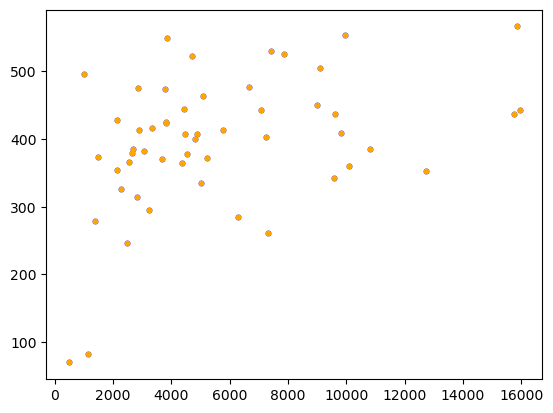

In [156]:
plt.scatter(final_table_filtered.loc['raw carbon'].loc[h_range[5]], final_table_filtered.loc['fresh_mass'].loc[''], s=10, c='blue')
plt.scatter(final_table_filtered.loc['raw carbon'].loc[h_range[8]], final_table_filtered.loc['fresh_mass'].loc[''], s=10, c='orange')

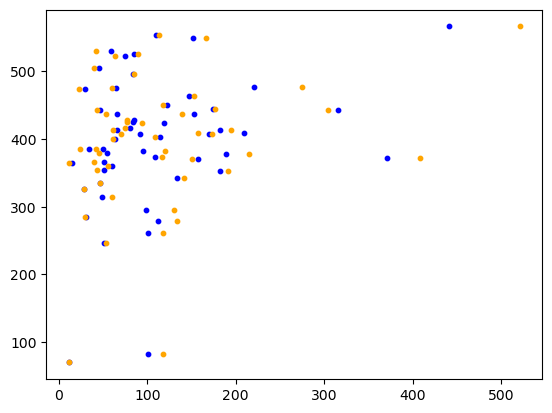

In [157]:
plt.scatter(final_table_filtered.loc['shared carbon'].loc[h_range[5]], final_table_filtered.loc['fresh_mass'].loc[''], s=10, c='blue')
plt.scatter(final_table_filtered.loc['shared carbon'].loc[h_range[8]], final_table_filtered.loc['fresh_mass'].loc[''], s=10, c='orange')

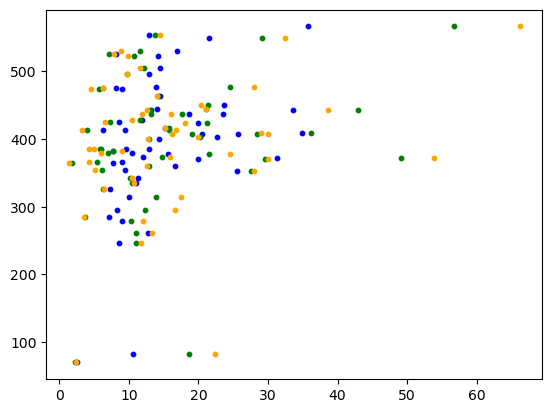

In [158]:
plt.scatter(final_table_filtered.loc['shared light carbon'].loc[h_range[2]], final_table_filtered.loc['fresh_mass'].loc[''], s=10, c='blue')
plt.scatter(final_table_filtered.loc['shared light carbon'].loc[h_range[5]], final_table_filtered.loc['fresh_mass'].loc[''], s=10, c='green')
plt.scatter(final_table_filtered.loc['shared light carbon'].loc[h_range[8]], final_table_filtered.loc['fresh_mass'].loc[''], s=10, c='orange')

In [159]:
if tree_name == 'E13' :
    path = resources.path('vmlab.data.results', 'exploration_E13_fruting_season_geom_MF.csv') 
if tree_name == 'E16' :
    path = resources.path('vmlab.data.results', 'exploration_E16_fruting_season_geom_MF.csv') 
if tree_name == 'G3' :
    path = resources.path('vmlab.data.results', 'exploration_G3_fruting_season_geom_MF.csv') 

np.transpose(final_table_filtered.swaplevel("variable","h",0).sort_index(axis=0,level="h")).to_csv(path_or_buf= path)

#### With initial dry fruit mass in the explaining variables : (FINAL OBJECTIVE)

In [160]:
# collecting variables at the distance dmax :
results = [get_var_fruit_growth(tree2, sunlit_fraction_df, h, demand='DM', distance = distance_impact_musca) for h in h_range]

# results are fitted into a dataframe :
col_names = pd.MultiIndex.from_product(([ h for h in h_range],["raw carbon", "shared carbon","shared light carbon"]), names=["h","variable"])
final_table = pd.DataFrame(np.transpose(np.vstack(results)), index=np.flatnonzero(is_fruting), columns=col_names)
final_table = final_table.swaplevel("h","variable",1).sort_index(axis=1,level="variable")

final_table["GU_type"] = tree.loc[tree['arch_dev__pot_nb_fruit'] >0]['type']

final_table['tree'] = np.full(fill_value = tree_name, shape = len(final_table.index))
final_table["fresh_mass"] = fruit_mass["MF_rec"]
final_table["dry_mass"] = fruit_mass["MS_ini"]

final_table = np.transpose(final_table)

final_table_filtered = final_table.drop(labels = [i for i in final_table.columns if np.any(final_table.loc["GU_type", i]!="GU")], axis=1)

In [161]:
if tree_name == 'E13' :
    path = resources.path('vmlab.data.results', 'exploration_E13_fruting_season_geom_MF.csv') 
if tree_name == 'E16' :
    path = resources.path('vmlab.data.results', 'exploration_E16_fruting_season_geom_MF.csv') 
if tree_name == 'G3' :
    path = resources.path('vmlab.data.results', 'exploration_G3_fruting_season_geom_MF.csv') 

np.transpose(final_table_filtered.swaplevel("variable","h",0).sort_index(axis=0,level="h")).to_csv(path_or_buf= path)

#### With no fruit mass in the explaining variables :

In [162]:
# collecting variables at the distance dmax :
results = [get_var_fruit_growth(tree2, sunlit_fraction_df, h, demand='1', distance = distance_impact_musca) for h in h_range]

# results are fitted into a dataframe :
col_names = pd.MultiIndex.from_product(([ h for h in h_range],["raw carbon", "shared carbon","shared light carbon"]), names=["h","variable"])
final_table = pd.DataFrame(np.transpose(np.vstack(results)), index=np.flatnonzero(is_fruting), columns=col_names)
final_table = final_table.swaplevel("h","variable",1).sort_index(axis=1,level="variable")

final_table["GU_type"] = tree.loc[tree['arch_dev__pot_nb_fruit'] >0]['type']

final_table['tree'] = np.full(fill_value = tree_name, shape = len(final_table.index))
final_table["fresh_mass"] = fruit_mass["MF_rec"]
final_table["dry_mass"] = fruit_mass["MS_ini"]

final_table = np.transpose(final_table)

final_table_filtered = final_table.drop(labels = [i for i in final_table.columns if np.any(final_table.loc["GU_type", i]!="GU")], axis=1)

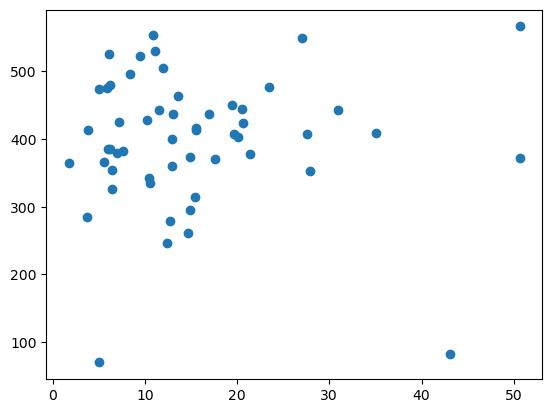

In [163]:
x = final_table_filtered.loc["shared light carbon"].loc[h_range[5]]
y = final_table_filtered.loc['fresh_mass'].loc['']
plt.scatter(x, y)

In [164]:
if tree_name == 'E13' :
    path = resources.path('vmlab.data.results', 'exploration_E13_fruting_season_geom.csv') 
if tree_name == 'E16' :
    path = resources.path('vmlab.data.results', 'exploration_E16_fruting_season_geom.csv') 
if tree_name == 'G3' :
    path = resources.path('vmlab.data.results', 'exploration_G3_fruting_season_geom.csv') 

np.transpose(final_table_filtered.swaplevel("variable","h",0).sort_index(axis=0,level="h")).to_csv(path_or_buf= path)

# Optimization : calibration of wood friction h

Testing descrete values for h makes it difficult to find a good friction value. This section aims to optimise RRMSE of the fit between model and data for h as a continuous variable.

In [165]:
import statsmodels.formula.api as smf

## Functions

In [166]:
def RRMSE (observed, predicted):
    ''' 
    Returns the  relative root mean square error between observed and predicted data.

    Parameters
    ----------
    observed : :class:`numpy.array` object

    predicted : :class:`numpy.array` object

    Returns
    -------
    RRMSE : :class:`float
    '''
    SCE = np.sum((predicted-observed)**2)
    RMSE = np.sqrt(SCE/len(observed))
    RRMSE = 100 * RMSE /np.mean(observed)
    return RRMSE

In [167]:
def model_weibull(x, asym, k, pwr):
    '''
    Returns the values of the Weibull to predict fresh fruit mass model not including dry mass.
    
    Parameters
    ----------
    x : :class:`numpy.array` object
        Available carbon.

    asym : :class:`float` object
        Fresh fruit mass asymptot in the model.

    k : :class:`float` object
        Parameter of the model.

    pwr : :class:`float` object
        Parameter of the model.

    Returns
    -------
    Values calculated : :class:`numpay.array
    '''
    return asym - asym*np.exp(-k*(x**pwr))

## Reference model calibrated on F14 branches

The last "final_table"

In [168]:
# reference parameters for F14 Weibull model (without dry mass) with dmax = 12 (best model)
asym_ref, k_ref, pwr_ref = 427, 0.091, 1.07

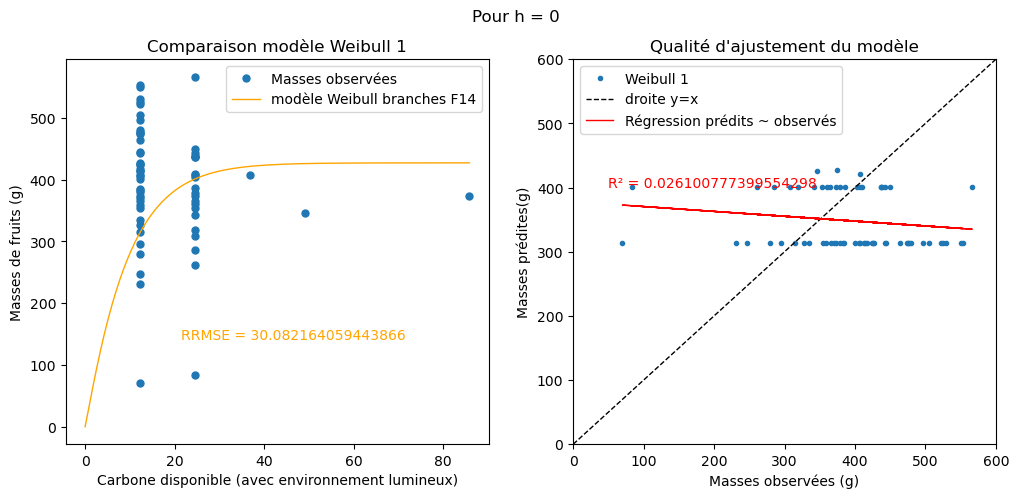

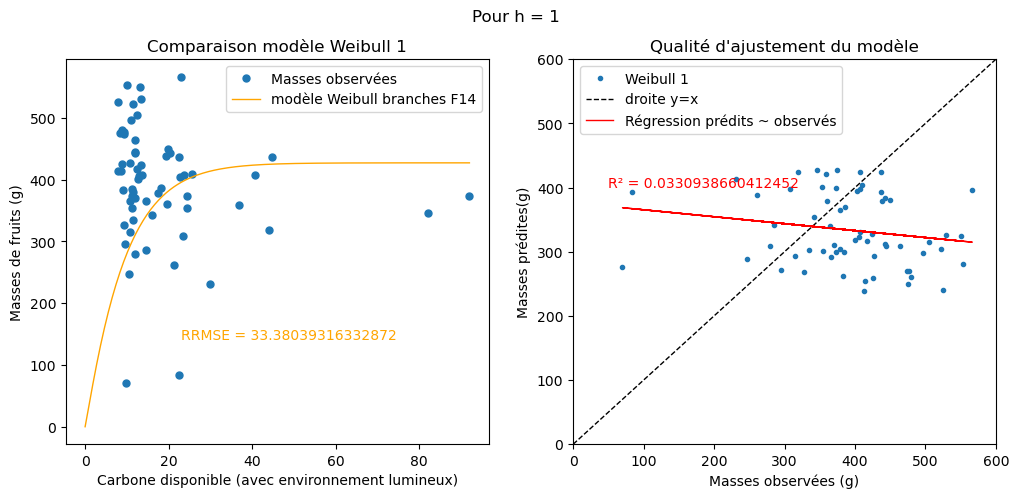

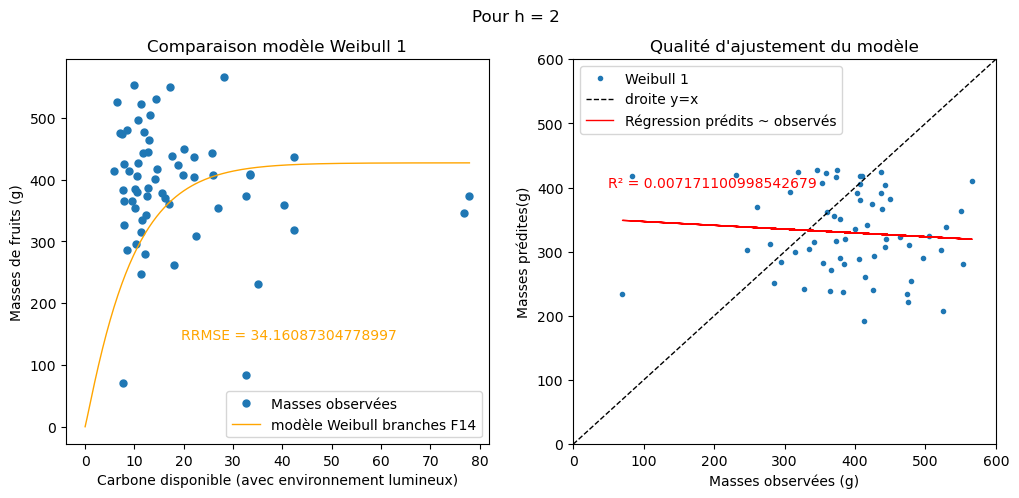

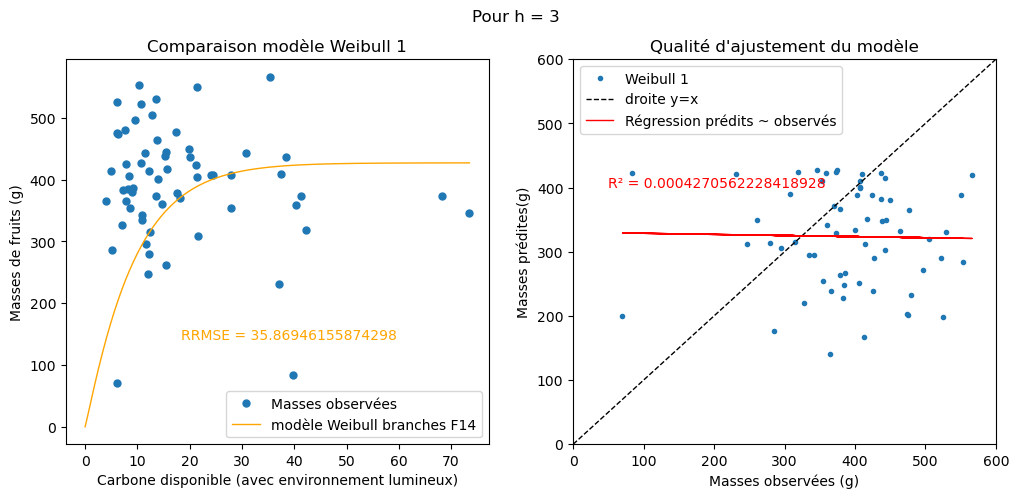

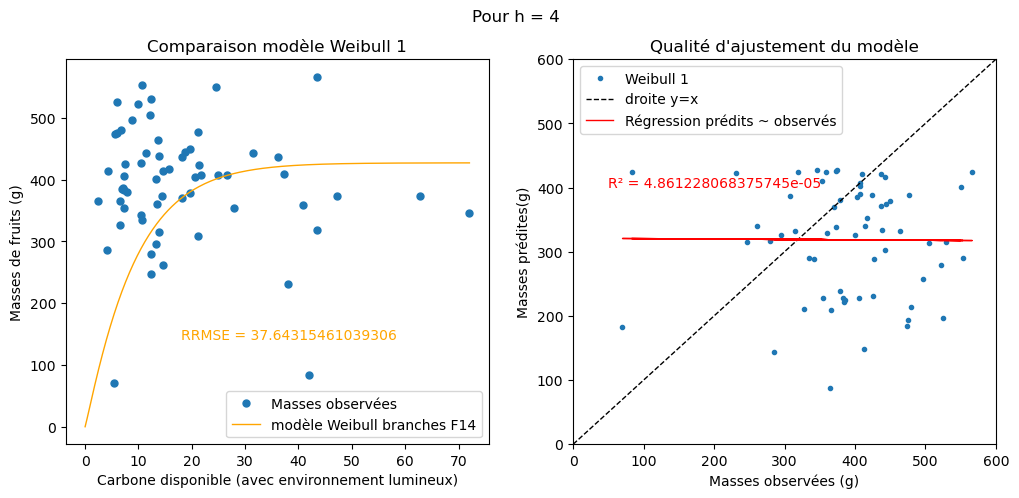

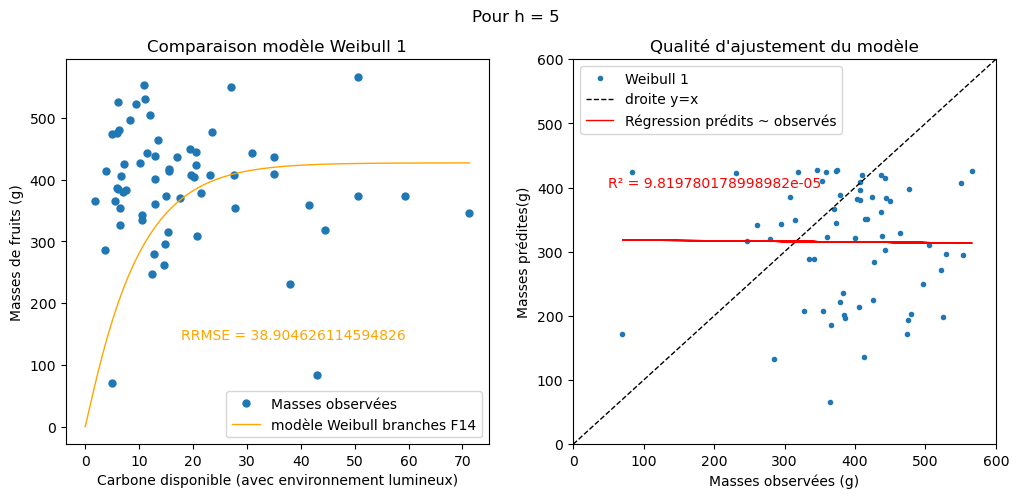

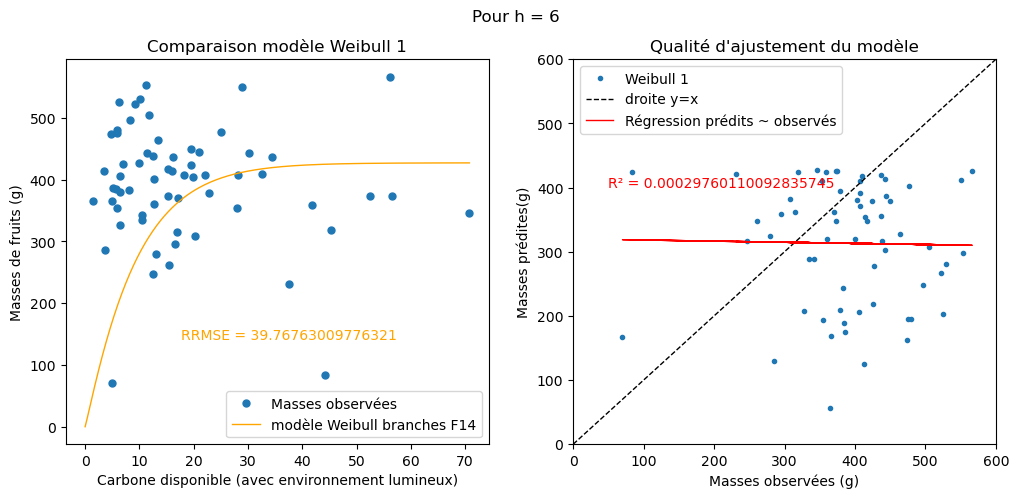

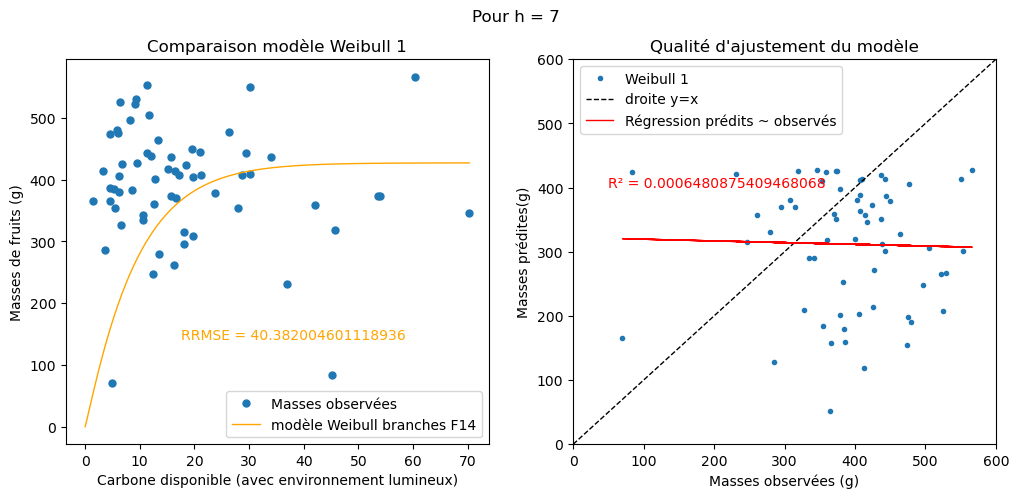

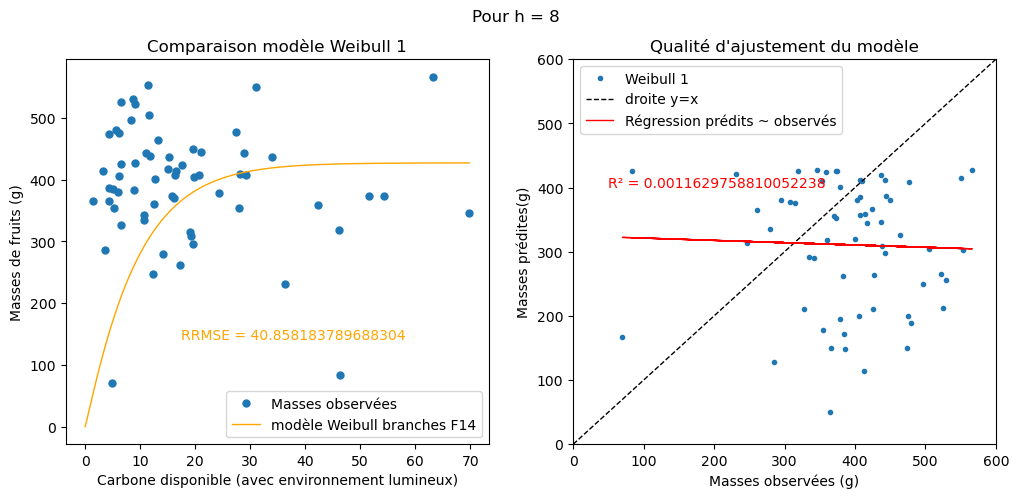

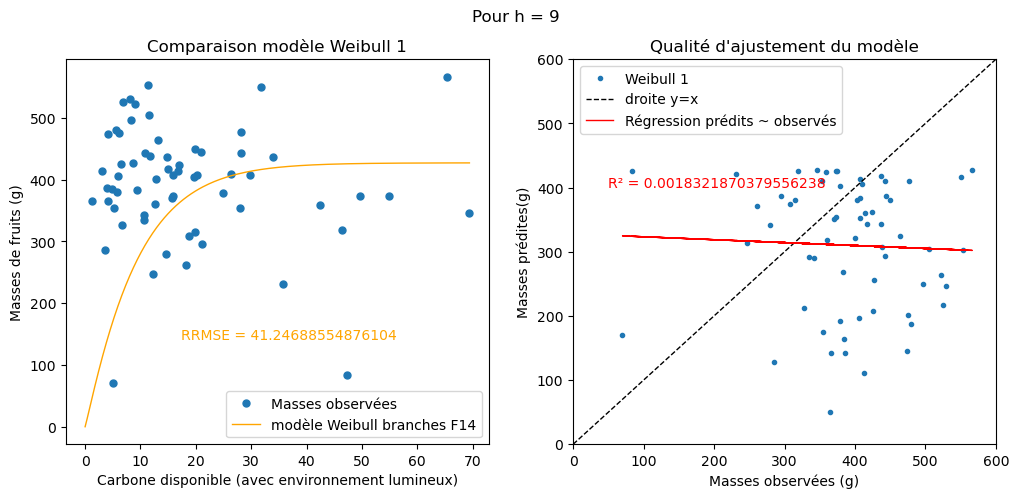

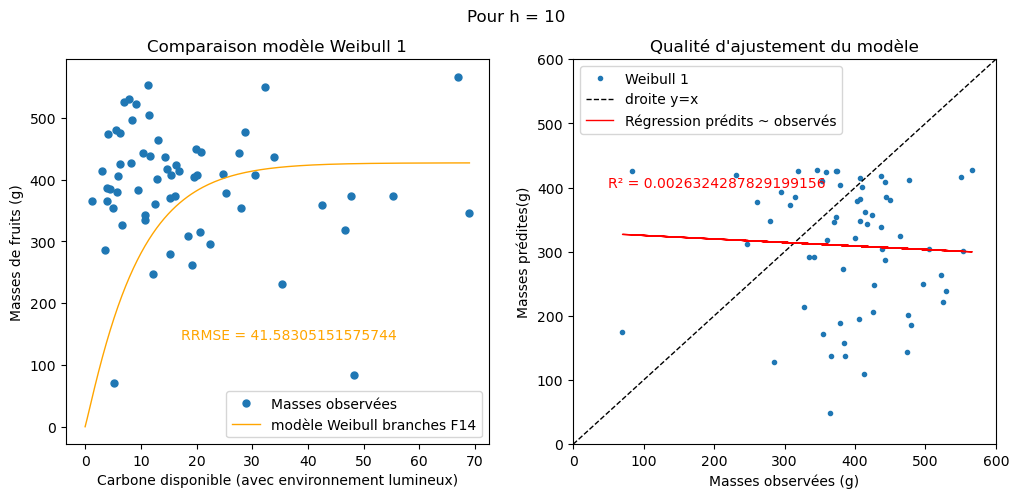

In [169]:
show_id_on_plot = False #can be True or False
rrmse = []
for i in  h_range :
      x = final_table.loc['shared light carbon'].loc[i].astype(float)
      y1 = final_table.loc['fresh_mass',""].astype(float)
      y2= model_weibull(x, asym_ref, k_ref, pwr_ref)
      sample=pd.DataFrame({'x':x, 'y1':y1, 'y2':y2, 'dry_mass': final_table.loc['dry_mass','']}).astype(float)
      
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize = (12,5))
      fig.suptitle("Pour h = "+str(i))

      sample.plot(x='x', y='y1',
            kind="line", title = "Comparaison modèle Weibull 1",
            linestyle="", marker=".",markersize=10,
            xlabel = 'Carbone disponible (avec environnement lumineux)', ylabel = 'Masses de fruits (g)',
            label = "Masses observées",
            ax = axs[0])
      if show_id_on_plot : 
            for xi, yi, text in zip(sample['x'], sample['y1'], sample.index):
                  axs[0].annotate(text, xy=(xi,yi), xycoords='data',
                              xytext=(1.5,1.5), textcoords='offset points')
      
      x = np.linspace(0, np.max(x),200)
      y= model_weibull(x, asym_ref, k_ref, pwr_ref)
      axs[0].plot(x,y, linestyle="-",linewidth=1,
                  color='orange', label='modèle Weibull branches F14')
      
      axs[0].text(x=np.max(sample['x'])/4, y=np.max(sample['y1'])/4, s= "RRMSE = "+ str(RRMSE(predicted = y2, observed = y1)), color='orange')
      axs[0].legend()

      rrmse.append(RRMSE(predicted = y2, observed = y1))
      sample.plot(x='y1', y='y2',
                  kind='line', title="Qualité d'ajustement du modèle",
                  linestyle='', marker='.',linewidth=1,
                  ax=axs[1], label = 'Weibull 1',
                  xlim =(0,600), ylim =(0,600),
                  xlabel = 'Masses observées (g)', ylabel = 'Masses prédites(g)')
      axs[1].plot([0,600],[0,600], color='black',linewidth=1, linestyle="--", label = 'droite y=x')
      axs[1].plot(sample['y1'], smf.ols('y2 ~ y1', data=sample).fit().predict(sample['y1']),
                  linewidth=1, label='Régression prédits ~ observés', color='red')
      axs[1].text(x=50, y=400, s= "R² = "+ str(smf.ols('y2 ~ y1', data=sample).fit().rsquared), color='red')
      axs[1].legend()

Text(0, 29, 'Fair')

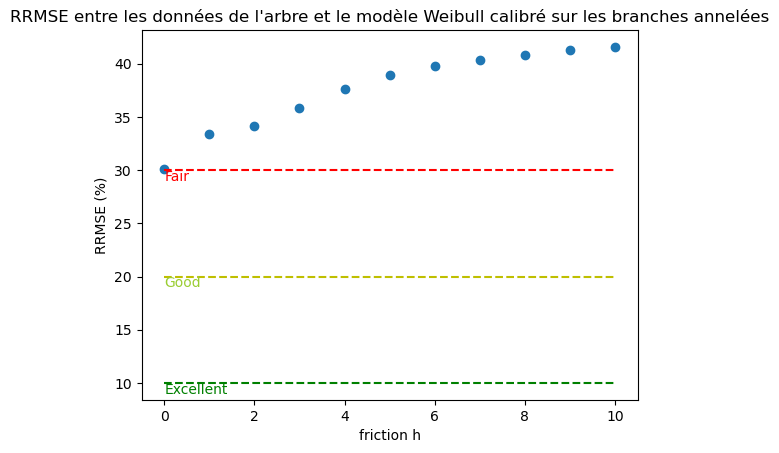

In [170]:
plt.scatter(h_range, rrmse)
plt.title("RRMSE entre les données de l'arbre et le modèle Weibull calibré sur les branches annelées")
plt.xlabel('friction h')
plt.ylabel('RRMSE (%)')
plt.plot([0,np.max(h_range)], [10,10], 'g--')
plt.plot([0,np.max(h_range)], [20,20], 'y--')
plt.plot([0,np.max(h_range)], [30,30], 'r--')
plt.text(x=0, y=9, s="Excellent", c='green')
plt.text(x=0, y=19, s="Good", c='yellowgreen')
plt.text(x=0, y=29, s="Fair", c='red')

Conclusion : plus h est élevé, donc plus la friction est forte dans l'arbre, et donc plus les échanges de carbones sont locaux, et moins le modèle calibré sur branche annelées est bon pour décrire les masses des fruits de l'arbre.

Quelque soit la friction, le modèle calibré sur F14 ne décrit pas bien les données ici.